In [13]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import yaml

from pyspark.sql import SparkSession

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

plt.style.use("seaborn-white")
conf_dict = yaml.safe_load(Path("config/dataprep.yaml").read_text())

spark = SparkSession.builder.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           .getOrCreate()

In [48]:
ownership_raw_df = spark.read.json(conf_dict["ownership_data_raw"])

In [49]:
ownership_raw_df.printSchema()

root
 |-- addresses: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- address: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- birthDate: string (nullable = true)
 |-- dissolutionDate: string (nullable = true)
 |-- entityType: string (nullable = true)
 |-- foundingDate: string (nullable = true)
 |-- identifiers: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- scheme: string (nullable = true)
 |    |    |-- schemeName: string (nullable = true)
 |    |    |-- uri: string (nullable = true)
 |-- incorporatedInJurisdiction: struct (nullable = true)
 |    |-- code: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- interestedParty: struct (nullable = true)
 |    |-- describedByEntityStatement: string (nullable = true)
 |    |-- describedByPersonStatement: string (nullable = tru

In [57]:
ownership_raw_df.groupBy("statementType").count().orderBy(F.desc("count")).show(truncate=False)

+---------------------------+--------+
|statementType              |count   |
+---------------------------+--------+
|ownershipOrControlStatement|11543312|
|personStatement            |8905554 |
|entityStatement            |8201380 |
+---------------------------+--------+



In [58]:
# Count of identifying schemes.
ownership_raw_df.filter("statementType == 'entityStatement'").select(F.explode("identifiers")).select("col.*").groupBy(
    "schemeName", "scheme"
).count().orderBy(F.desc("count")).show(truncate=False)


+-----------------------------------------------------------------+-------+-------+
|schemeName                                                       |scheme |count  |
+-----------------------------------------------------------------+-------+-------+
|OpenOwnership Register                                           |null   |8201380|
|OpenCorporates                                                   |null   |8059582|
|Companies House                                                  |GB-COH |7233049|
|GB Persons Of Significant Control Register                       |null   |715217 |
|Danish Central Business Register                                 |DK-CVR |437926 |
|United State Register                                            |UA-EDR |385417 |
|GB Persons Of Significant Control Register - Registration numbers|null   |334305 |
|Ministry of Justice Business Register                            |SK-ORSR|29920  |
|SK Register Partnerov Verejného Sektora                          |null   |2

In [67]:
# GB companies with missing IDs.
# - looks like 
ownership_raw_df.filter("statementType == 'entityStatement'").select(
    "*", F.explode("identifiers")
).select("name", "col.*").drop("col").filter((
    F.col("schemeName").startswith("GB"))
).groupBy("name", F.length("id") < 50).count().show(truncate=False)


+-------------------------------------------+-----------------+-----+
|name                                       |(length(id) < 50)|count|
+-------------------------------------------+-----------------+-----+
|CAPITA PLC                                 |false            |109  |
|UK FINANCIAL INVESTMENTS LIMITED           |true             |1    |
|CGL GAMING PLC                             |false            |1    |
|SVGC MANAGERS LIMITED                      |true             |1    |
|BLENPARK PROPERTIES LIMITED                |true             |2    |
|ROCK RAIL HOLDINGS LIMITED                 |true             |1    |
|MIRUM AGENCY UK LIMITED                    |false            |1    |
|Merilux S.à r.l.                           |true             |1    |
|YORK UNIVERSITY DEVELOPMENT COMPANY LIMITED|false            |1    |
|ROBERTSON GROUP (HOLDINGS) LIMITED         |true             |2    |
|ROBERTSON CONSTRUCTION GROUP LIMITED       |true             |2    |
|RESTORE PLC        

In [37]:
companies_interim_path = conf_dict["companies_interim"]
relationships_interim_path = conf_dict["relationships_interim"]
persons_interim_path = conf_dict["persons_interim"]

In [38]:
companies_interim_df = spark.read.parquet(companies_interim_path)
relationships_interim_df = spark.read.parquet(relationships_interim_path)
persons_interim_df = spark.read.parquet(persons_interim_path)

In [15]:
companies_processed_path = str(Path(conf_dict["companies_processed"]).absolute())
relationships_processed_path = str(
    Path(conf_dict["relationships_processed"]).absolute()
)
persons_processed_path = str(Path(conf_dict["persons_processed"]).absolute())
addresses_processed_path = str(Path(conf_dict["addresses_processed"]).absolute())

In [16]:
companies_processed_df = spark.read.parquet(companies_processed_path)
relationships_processed_df = spark.read.parquet(relationships_processed_path)
persons_processed_df = spark.read.parquet(persons_processed_path)
addresses_processed_df = spark.read.parquet(addresses_processed_path)

In [17]:
all_dfs_dict = {
    "companies": companies_processed_df,
    "relationships": relationships_processed_df,
    "persons": persons_processed_df,
    "addresses": addresses_processed_df,
}

In [18]:
companies_processed_df.columns

['statementID',
 'name',
 'foundingDate',
 'CompaniesHouseID',
 'OpenCorporatesID',
 'OpenOwnershipRegisterID',
 'CompanyCategory',
 'CompanyStatus',
 'Accounts_AccountCategory',
 'SICCode_SicText_1']

In [19]:
companies_processed_df.groupBy(
    F.col("CompaniesHouseID").isNull(), F.col("SICCode_SicText_1").isNull()
).count().show()

+--------------------------+---------------------------+-------+
|(CompaniesHouseID IS NULL)|(SICCode_SicText_1 IS NULL)|  count|
+--------------------------+---------------------------+-------+
|                      true|                       true|  11263|
|                     false|                      false|4882242|
|                     false|                       true| 503393|
+--------------------------+---------------------------+-------+



In [25]:
no_ch_id = companies_processed_df.filter(F.col("CompaniesHouseID").isNull()).limit(
    10
).toPandas()

In [39]:
for row in no_ch_id.itertuples():
    print(row)
    break

Pandas(Index=0, statementID='10048923785449092960', name='Nicholson Group Ltd', foundingDate=None, CompaniesHouseID=None, OpenCorporatesID=None, OpenOwnershipRegisterID='http://register.openownership.org/entities/59b9a5f267e4ebf34037340f', CompanyCategory=None, CompanyStatus=None, Accounts_AccountCategory=None, SICCode_SicText_1=None)


In [47]:
companies_interim_df.filter("name == 'Nicholson Group Ltd'").select(F.explode("identifiers")).select("col.*").show(truncate=False)


+-----------------------------------------------------------------------------------------------+------+-----------------------------------------------------------------+-------------------------------------------------------------------+
|id                                                                                             |scheme|schemeName                                                       |uri                                                                |
+-----------------------------------------------------------------------------------------------+------+-----------------------------------------------------------------+-------------------------------------------------------------------+
|/company/07194933/persons-with-significant-control/corporate-entity/P2FmFTaT3xm9Nb4ze2WAYXtRK7A|null  |GB Persons Of Significant Control Register                       |null                                                               |
|69742941                                   

In [12]:
for key, df in all_dfs_dict.items():
    print(key)
    print("-" * 79)
    print(f"{df.count():,}")
    df.printSchema()
    print()

companies
-------------------------------------------------------------------------------
5,396,898
root
 |-- statementID: string (nullable = true)
 |-- name: string (nullable = true)
 |-- foundingDate: string (nullable = true)
 |-- CompaniesHouseID: string (nullable = true)
 |-- OpenCorporatesID: string (nullable = true)
 |-- OpenOwnershipRegisterID: string (nullable = true)
 |-- CompanyCategory: string (nullable = true)
 |-- CompanyStatus: string (nullable = true)
 |-- Accounts_AccountCategory: string (nullable = true)
 |-- SICCode_SicText_1: string (nullable = true)


relationships
-------------------------------------------------------------------------------
5,704,926
root
 |-- interestedPartyStatementID: string (nullable = true)
 |-- interestedPartyIsPerson: boolean (nullable = true)
 |-- subjectStatementID: string (nullable = true)
 |-- minimumShare: double (nullable = true)


persons
-------------------------------------------------------------------------------
5,470,338
root


In [9]:
companies_processed_df.limit(10).toPandas()

,statementID,name,foundingDate,CH,OC,OOR
0,1000033676574176544,CAMEL CLUB NFT LIMITED,2021-10-08,13669988,https://opencorporates.com/companies/gb/13669988,http://register.openownership.org/entities/616...
1,10000859118742385388,SQUAREDEAL UPVC & RENEWABLES LTD,2012-12-13,08330033,https://opencorporates.com/companies/gb/08330033,http://register.openownership.org/entities/59b...
2,10001867314858559305,WARRENWEB LIMITED,2013-03-01,08426436,https://opencorporates.com/companies/gb/08426436,http://register.openownership.org/entities/59b...
3,10002587336144954731,CONRAD MERRIN LIMITED,2004-09-16,05232981,https://opencorporates.com/companies/gb/05232981,http://register.openownership.org/entities/59b...
4,10002752670790900952,NAILUXURY GROUP LTD,2021-08-06,13552120,https://opencorporates.com/companies/gb/13552120,http://register.openownership.org/entities/612...
5,10003141118547630350,FYLE LIMITED,1987-10-06,02174414,https://opencorporates.com/companies/gb/02174414,http://register.openownership.org/entities/59b...
6,10003241762341667787,N GILL CONSULTING LIMITED,2017-01-13,10562004,https://opencorporates.com/companies/gb/10562004,http://register.openownership.org/entities/59b...
7,10003389106442263850,ELTA FANS LIMITED,1964-09-25,00820750,https://opencorporates.com/companies/gb/00820750,http://register.openownership.org/entities/59b...
8,10003572037962552078,WAXED FLOORS LIMITED,2003-05-13,04762979,https://opencorporates.com/companies/gb/04762979,http://register.openownership.org/entities/59b...
9,10003663476768466092,KMWS (E-COMMERCE) LTD,2020-10-20,12963051,https://opencorporates.com/companies/gb/12963051,http://register.openownership.org/entities/5f9...


## Graph

In [17]:
import igraph as ig

In [18]:
edges = relationships_processed_df.select(
    "interestedPartyStatementID", "subjectStatementID"
)
edges.count()

5704926

In [19]:
edge_list = [tuple(v for v in e) for e in edges.collect()]
# edge_list = [e for e in edges.collect()]

In [20]:
import itertools as it

graph = ig.Graph()
vertex_list = list(set(it.chain.from_iterable(edge_list)))
graph.add_vertices(vertex_list)
del vertex_list

In [21]:
graph.add_edges(edge_list)

In [25]:
clusters = graph.clusters("weak")
cluster_sizes = clusters.sizes()

52

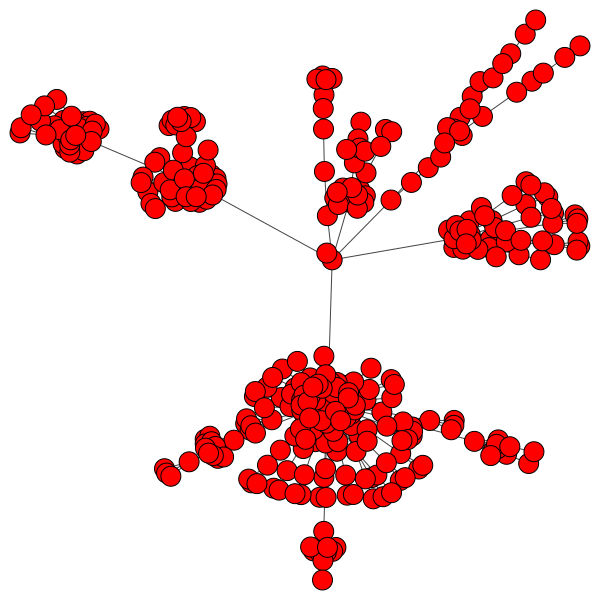

: 

In [55]:
subg_id = next(
    (idx, size) for idx, size in enumerate(cluster_sizes) if 200 < size < 500
)
subg = clusters.subgraph(subg_id[0])
subg.vcount()
ig.plot(subg)